In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.tools.visualization import plot_histogram
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister,execute, Aer

In [3]:
# Function to create the cost Hamiltonian for the TSP
def create_cost_Hamiltonian(distances):
    n_cities = len(distances)
    H = np.zeros((n_cities, n_cities))
    for i in range(n_cities):
        for j in range(n_cities):
            if i != j:
                H[i][j] = distances[i][j]
    return H

In [4]:
# Function to create the mixer Hamiltonian for the TSP
def create_mixer_Hamiltonian(n_cities):
    H = np.ones((n_cities, n_cities)) - np.eye(n_cities)
    return H

In [5]:
# Function to create the QAOA circuit for the TSP
def create_QAOA_circuit(distances, p):
    n_cities = len(distances)
    
    # Create quantum registers and classical register
    qr = QuantumRegister(n_cities)
    cr = ClassicalRegister(n_cities)
    
    # Create quantum circuit
    qc = QuantumCircuit(qr, cr)
    
    # Create cost and mixer Hamiltonians
    cost_H = create_cost_Hamiltonian(distances)
    mixer_H = create_mixer_Hamiltonian(n_cities)
    
    # Apply QAOA steps
    for i in range(p):
        # Apply cost Hamiltonian
        for j in range(n_cities):
            for k in range(j+1, n_cities):
                qc.cx(qr[j], qr[k])
                qc.p(-cost_H[j][k], qr[k])
                qc.cx(qr[j], qr[k])
        # Apply mixer Hamiltonian
        for j in range(n_cities):
            qc.h(qr[j])
            qc.x(qr[j])
        qc.barrier()
        for j in range(n_cities):
            for k in range(j+1, n_cities):
                qc.cx(qr[j], qr[k])
                qc.p(-mixer_H[j][k], qr[k])
                qc.cx(qr[j], qr[k])
        for j in range(n_cities):
            qc.x(qr[j])
            qc.h(qr[j])
    
    # Measure qubits
    for j in range(n_cities):
        qc.measure(qr[j], cr[j])
    
    
    return qc

In [6]:
cities = ['A', 'B', 'C', 'D']
distances= [[0, 45, 20, 5], [45, 0, 35, 25], [20, 30, 0, 30], [5, 25, 30, 0]]

cv = create_QAOA_circuit(distances, 200)
# cv.draw(output = 'mpl')

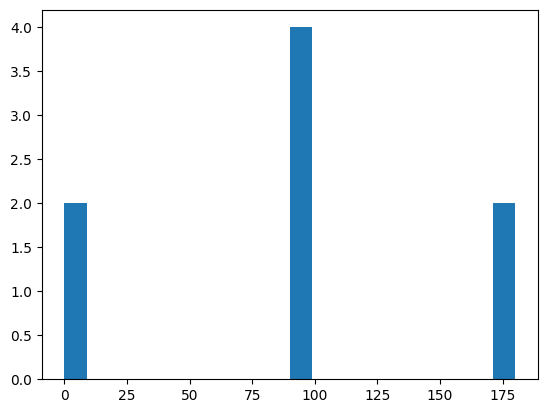

[90, 0, 180, 90, 0, 180, 90, 90]


In [7]:
# Execute the circuit on a simulator backend
backend = Aer.get_backend('qasm_simulator')
result = execute(cv, backend , shots=2047).result()

# Extract the results from the execution object
counts = result.get_counts()

# Initialize the list of optimal costs
optimal_costs = []

# Iterate over the results
for bitstring, count in counts.items():
    # Convert the bitstring to a list of integers
    path = [int(x) for x in bitstring]
    
    # Compute the cost of the path
    cost = 0
    for i in range(len(path)-1):
        cost += distances[path[i]][path[i+1]]
    cost += distances[path[-1]][path[0]]
    
    # Append the cost to the list
    optimal_costs.append(cost)

# Plot the histogram of optimal costs
plt.hist(optimal_costs, bins=20)
plt.show()
print(optimal_costs)

In [9]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx


from qiskit_aer import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [10]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)